# Model

## Kevin Shain

### 05/05/2016

In [2]:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random as rng
import math
from numpy import pi
from qubitparameterestimation import myio
from qubitparameterestimation import model

# Table of Contents
* [Generative Model](#Generative-Models)
    * [Long time-scale errors](#Long-time-scale-errors)
	* [Model with drift and diffusion](#Model-with-drift-and-diffusion)
* [Likelihood function](#Likelihood-function)
* [Fourier Representation](#Fourier-Representation)
    * [Product as a sum](#Product-as-a-sum)
    * [Iterative update](#Iterative-update)
    * [Drift and diffusion](#Drift-and-diffusion)
* [Expectation values](#Expectation-values)
    * [Expected ΔBz](#Expected-ΔBz)
    * [Expected variance](#Expected-variance)
* [Adaptive evolution time algorithm](#Adaptive-evolution-time-algorithm)


# Generative Model

Because each measurement of a qubit probabilistically projects the a superposition state that exists somewhere on the qubit's Bloch sphere onto either the singlet or triplet state that is read out, my model is inherently probabilistic. Therefore, beyond adding random noise to the model, my model will generate probabilities of each measurement outcome and then randomly generate singlet(+1) or triplet(-1) for the measurement outcome.

Another important aspect to these models is that there are different timescales for different effects. Some parameters, like measurement error, state preparation error, and non-orthogonal axis of rotation, are consistent throughout the lifetime of the qubit. This means that we can accurately measure values for those error parameters over thousands or millions of measurements. This means that for real-time or limited measurement purposes, we can focus on the parameters that vary over a shorter time scale, like $\Delta B_z$ and its drift and diffusion. This tends to vary significantly on a time scale of a millisecond compared to measurements that take ~4 microseconds.

## Long time-scale errors

In general, we can say that the state of our qubit without noise is,

$$\left|\psi(t)\right>=\cos(\pi\Delta B_z t)\left|+\right>-i\sin(\pi\Delta B_z t)\left|-\right>$$

The probabilities for a given outcome as it depends on $\Delta B_z$ is therefore,

$$P(+|\Delta B_z)=\cos^2(\pi\Delta B_z t)$$
$$P(-|\Delta B_z)=\sin^2(\pi\Delta B_z t)$$

This simple model of the probabilities doesn't consider any errors, but it is important to note that it will still generate a random measurement outcome with defined probabilities so we will not be able to fit data from this model exactly even if we know $\Delta B_z$. The first source of error that I'll consider is measurement error. Essentially, the readout of the qubit is done by measuring voltage across another quantum dot. This gives well differentiated Gaussian peaks of voltage depending on the qubit state. These peaks are then thresholded so that the singlet(triplet) peak is marked +(-). This thresholding process is imperfect as there is some small chance that a tail from the singlet Gaussian will leak into the triplet region or vice versa. Ideally, I would not do the thresholding as that is an extra step of data processing. It is unclear whether the added complexity of using raw voltage measurements is worth the computational cost, but I'll make a model that generates voltage measurements later so that comparisons can be made. For now, I'll simply work with $\pm$ but include a measurement error term.

With measurement error, the probability of measuring a + is essentially the probability of measuring + correctly plus the probability of measuring - incorrectly. If we say that the probability of incorrectly measuring +(-) is $\eta_+(\eta_-)$, this gives us,

$$P(+|\Delta B_z)=(1-\eta_+)\cos^2(\pi\Delta B_z t)+\eta_-\sin^2(\pi\Delta B_z t)$$
$$P(-|\Delta B_z)=\eta_+\cos^2(\pi\Delta B_z t)+(1-\eta_-)\sin^2(\pi\Delta B_z t)$$

We can account for state preparation error in a similar way. The initial state would ideally be purely singlet every time, but it actually is prepared in the triplet state some small percentage of the time. This means that the initial density matrix is,

$$\begin{pmatrix}
 1-\epsilon & 0 \\ 
 0 & \epsilon
 \end{pmatrix}$$
 
Accounting for just state preparation error, we would have,

$$P(+|\Delta B_z)=(1-\epsilon)\cos^2(\pi\Delta B_z t)+\epsilon\sin^2(\pi\Delta B_z t)$$
$$P(-|\Delta B_z)=\epsilon\cos^2(\pi\Delta B_z t)+(1-\epsilon)\sin^2(\pi\Delta B_z t)$$

Finally, we have axis of rotation error. This accounts for small differences in the electric potential between the two quantum dots that make up the qubit. This shifts the axis of rotation on the Bloch sphere about which the state vector rotates. This error alone leads to,

$$P(+|\Delta B_z)=\cos^2(\pi\Delta B_z t)+\delta\sin^2(\pi\Delta B_z t)$$
$$P(-|\Delta B_z)=(1-\delta)\sin^2(\pi\Delta B_z t)$$

Putting the all of the errors together and using $\cos^2(x)-\sin^2(x)=\cos(2x)$, we get,

$$P(+|\Delta B_z)=\eta_-+\frac{1}{2}(1-\eta_+-\eta_-)[1+(1-2\epsilon)(\delta+(1-\delta)\cos(2\pi\Delta B_zt))]$$ 
$$P(-|\Delta B_z)=\eta_++\frac{1}{2}(1-\eta_+-\eta_-)[1-(1-2\epsilon)(\delta+(1-\delta)\cos(2\pi\Delta B_zt))]$$ 


We can combine these probabilities into one if we say the result of any measurement is $m_k=\pm 1$ so,

$$P(m_k|\Delta B_z)=\eta_-+\frac{1}{2}(1-\eta_+-\eta_-)[1+m_k(1-\epsilon)(\delta+(1-\delta)\cos(2\pi\Delta B_zt))]$$

We can reparameterize our long time-scale errors using

$$\alpha=\eta_--\eta_++(1-\eta_--\eta_+)(\delta-2\epsilon\delta)$$
$$\beta=(1-\eta_--\eta_+)(1-\delta)(1-2\epsilon)$$

to get,

$$P(m_k|\Delta B_z)=\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi\Delta B_zt))]$$


## Model with drift and diffusion

To address drift in $\Delta B_z$, we can use the approximation that $\Delta B_z$ is constant within the measurement evolution time of a single measurement. A reasonable estimate of the drift is $25kHz/\mu s$. The evolution times of a single measurement are 10-100 ns which justifies this approximation. However, each measurement in total takes $~4\mu s$ so we have to take into account the drift between measurements.

To address diffusion in $\Delta B_z$, we again use the approximation that $\Delta B_z$ is constant within the measurement evolution time of a single measurement. A reasonable estimate of the diffusion is $7 kHz^2/\mu s$. We want to first define a function that executes a random walk of $\Delta B_z$ that has the desired diffusion constant. This means, that we want,

$$\frac{\partial P}{\partial t}=D\frac{\partial^2 P}{\partial x^2}$$

We can solve this to say,

$$P(x,t) = \frac{1}{\sqrt{4\pi Dt}}e^{-x^2/4Dt}$$

Therefore, if we say that each step in our random walk is $1\mu s$, we can use our probability distribution to choose an updated $\Delta B_z$ such that it follows the proper rate of diffusion.

In [3]:
def randomWalk(Bz):
    """
    returns a vector with Bz values that have diffused over time. Each step is 1 microsecond
    so in practice, each consequtive measurement pulls its DeltaBz from every fourth
    value in the vector
    
    Parameters:
        Bz: Initial value of DeltaBz in the model (in MHz)
    """
    D = 7*10**(-6) # need to change from kHz^2 to MHz^2
    
    steps = 10000 # This allows for plenty of time to make ~100 measurements
    BzDiffused = np.empty(steps)
    BzDiffused[0] = Bz
    sigma = np.sqrt(2*D)
    for t in range(1,steps):
        BzDiffused[t] = np.random.normal(BzDiffused[t-1], sigma)
    return BzDiffused

In [4]:
def measurementDriftDiffusion(BzDiffused,t,drift,k):
    """
    returns either +1 or -1 with probability determined by the model for qubit evolution
    and projective measurement
    
    Parameters:
        BzDiffused: A vector of Bz values at 1 microsecond increments(in MHz)
        t: evolution time between state preparation and measurement (in nanoseconds)
        drift: rate of drift of DeltaBz in kHz/us
        k: measurement index
    """
    alpha=0.25
    beta=0.67
    driftHzs = drift*10**9 #units of Hz/s
    timePerMeasurement = 4*10**(-6)
    
    
    BzHertz = BzDiffused[4*k]*10**6 # each measurement looks at every 4th value of BzDiffused
                                    # since a measurement takes 4 microseconds
    tseconds = t*10**(-9)
    
    BzCurrent = BzHertz - driftHzs*timePerMeasurement*(k-1)
    pPlus = 1/2*(1+(alpha+beta*np.cos(2*pi*BzCurrent*tseconds)))
    x = np.random.rand(1)[0]
    if (pPlus > x):
        x = 1
    else:
        x = -1
    return x

# Likelihood function

In some sense, obtaining a likelihood function from the model is straightforward because before projecting the state to + or -, our model gives probabilities of + or -. This means that to find the likelihood of a series of measurements, we can take the product of the probability that each measurement would result in the outcome that was actually obtained. This is complicated a bit by the fact that our parameters are changing between measurements in a non-deterministic way. Specifically, the diffusion means that we have uncertainty in our parameter $\Delta B_z$ and that this uncertainty changes across the series of measurements. To account for this, I'll integrate my likelihood over the possible values of $\Delta B_z$. Our parameters are thus the initial $\Delta B_z$ and its drift, which together determine the mean value, and the diffusion constant that determines the variance of $\Delta B_z$ values that we must integrate over to get the likelihood of each measurement.

The likelihood of a single measurement given a value of $\Delta B_z$ is given by 

$$P(m_k|\Delta B_z)=\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi\Delta B_zt))]$$

However, since we are saying that $\Delta B_z$ drifts at some rate per measurement time, $v$, we should say,

$$P(m_k|\Delta B_z)=\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi(\Delta B_z+vk)t)]$$

Finally, the diffusion of $\Delta B_z$ with a diffusion constant per measurement time, $D$, means that we can say there is a distribution for $\Delta B_z$ at each measurement given by,

$$\Delta B_{z_k}=\frac{1}{\sqrt{4\pi Dk}}e^{-[\Delta B_{z_k}-(\Delta B_{z_0}+vk)]^2/4Dk}$$

Combining everything we have for a single measurement, we have,

$$P(m_k|\Delta B_{z_0},v,D)=\int_{-\infty}^\infty\frac{1}{\sqrt{4\pi Dk}}e^{-[\Delta B_{z_k}-(\Delta B_{z_0}+vk)]^2/4Dk}\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi(\Delta B_z+vk)t)]d\Delta B_{z_k}$$


Finally, we can write the likelihood for a series of measurements as,

$$P(\{m\}|\Delta B_{z_0},v,D)=\prod_k\int_{-\infty}^\infty\frac{1}{\sqrt{4\pi Dk}}e^{-[\Delta B_{z_k}-(\Delta B_{z_0}+vk)]^2/4Dk}\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi(\Delta B_{z_0}+vk)t)]d\Delta B_{z_k}$$

To actually implement this, we can evaluate the Gaussian integral for $P(m_k|\Delta B_{z_0},v,D)$. This is done by decomposing the cosine term into exponentials and then integrating the complex Gaussian analytically. If we say that the current value of $\Delta B_z$ taking into account just the initial value and drift is $\Delta B_{zc}$, then we have,

$$P(m_k|\Delta B_{zc},v,D)=\int_{-\infty}^\infty\frac{1}{\sqrt{4\pi Dk}}e^{-[\Delta B_{z_k}-\Delta B_{zc}]^2/4Dk}\frac{1}{2}[1+m_k(\alpha+\beta\cos(2\pi\Delta B_{zc}t)]d\Delta B_{z_k}$$
$$=\frac{1}{2}\sqrt{2Dk}e^{-(2\pi t)^2(2Dk)/2}\beta m_k\cos(2\pi\Delta B_{zc}t)+\frac{1}{2}\left(1+\alpha*m_k\right)$$

We can code this up by making a loop that updates the value of $\Delta B_{zc}$ and $\sqrt{2Dk}$ for each measurement and then multiplies the likelihood of that measurement to the total likelihood of the data.

In [5]:
def likelihood(MetaSeries,Bz):
    alpha = MetaSeries.alpha
    beta = MetaSeries.beta
    drift = MetaSeries.drift*10**9
    diffusion = MetaSeries.diffusion*10**(-6)
    BzHertz = Bz*10**6
    
    timePerMeasurement = 4*10**(-6)
    
    likelihood=1
    
    for i in range(len(MetaSeries)):
        k = MetaSeries[i,0]+1
        tk = MetaSeries[i,1]*10**(-9)
        mk = MetaSeries[i,2]
        
        BzCurrent = BzHertz - drift*timePerMeasurement*(k+1)
        sigma = np.sqrt(2*diffusion*4*k)
        
        likelihoodmk = 1/2*beta*mk*sigma*np.exp(-(2*pi*tk)**2*sigma**2/2)*np.cos(2*pi*BzCurrent*tk)+(1+mk*alpha)/2
        likelihood = likelihood*likelihoodmk
    return likelihood

# Sample Inference

First, I'll load a sample dataset generated with a $\Delta B_z$ of 60MHz.

In [6]:
test = myio.loadData('singleSeries.csv')

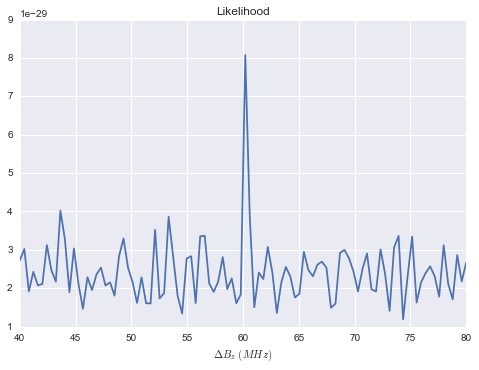

In [7]:
Bz = np.linspace(40,80,100)
plt.plot(Bz,likelihood(test,Bz))
plt.title('Likelihood')
plt.xlabel(r'$\Delta B_z\,\,(MHz)$')

# Fourier Representation

## Product as a sum

Repeatedly using the identity $\cos(a)\cos(b)=\frac{1}{2}\left[\cos(a+b)+\cos(a-b)\right]$, we can transform the posterior from a product to a sum.

$$P_k(\Delta B_z|\{m\})=A\,P_0(\Delta B_z)\prod_{i=1}^k P_i(m_i|\Delta B_z)=A\sum_{q=-K}^K c_k(q)\cos(2\pi\tau q\Delta B_z)
$$

where $A$ is just a normalization constant, $P_0(\Delta B_z)$ is the uniform prior, and $K=\sum_{i=1}^k m_i$ represents the maximum number of terms necessary to represent the posterior exactly.
The posterior can easily be normalized in the Fourier picture by dividing through by $\frac{c_k(0)}{2\tau}$ to yield,
$$P_k(\Delta B_z|\{m\})=\sum_{q=-K}^K \frac{c_k(q)}{2\tau c_k(0)}\cos(2\pi\tau q\Delta B_z)
$$

## Iterative update

The coefficients can be updated after each measurement since each coeffient will just depend on its previous value and the coefficients connected to it by the $(a+b)$ and $(a-b)$ in the cosine identity. Thus,
$$
c_{k+1}(q)=(1 + m_{k+1}\alpha)c_{k}(q) + m_{k+1}\beta [c_{k}(q+n_{k+1})+ c_{k}(q-n_{k+1})]
$$

This can be implemented efficiently by treating the coefficients as vectors and just using index shifts to do the update.

## Drift and diffusion

The drift and diffusion can be handled in the Fourier representation simply by taking the Fourier transform of the drift and diffusion operators. For the drift operator, $\Delta B_z\rightarrow\Delta B_z+v\Delta t$ acting on the Fourier coefficients is,
$$
c(q)\rightarrow e^{-i(2\pi \tau q)v\Delta t}c(q)
$$
where $\tau$ is the minimum measurement time which sets the bandwidth of the experiment. A reasonable value for $\tau$ is 10 ns which gives a bandwidth of 50 MHz.
The diffusion operator for the Fourier coefficients is,
$$
c(q)\rightarrow e^{-D(2\pi \tau q)^2\Delta t}c(q)
$$
This makes the total coefficient update,
$$
c_{k+1}(q)=e^{-D(2\pi \tau q)^2\Delta t-i(2\pi \tau q)v\Delta t} \{(1 + m_{k+1}\alpha)c_{k}(q) + m_{k+1}\beta [c_{k}(q+n_{k+1})+ c_{k}(q-n_{k+1})]\}
$$

# Expectation values

## Expected ΔBz

Evaluating expectation values from the posterior is now the convolution of the posterior with the quantity to be averaged. For example,
\begin{equation}
\left<\Delta B_z\right>=\int_{\frac{1}{2\tau}}^{\frac{2}{2\tau}}\Delta B_zP_k(\Delta B_z|\{m\})d\Delta B_z
\end{equation}
where the limits of integration are designed to be span the bandwidth of the Fourier series, 50 MHz, with bounds determined by the prior which is uniform and nonzero from 50 MHz to 100 MHz. This yields the desired result of converting to the Fourier domain. The convolution integral can be expressed as the sum of the product of $\Delta B_z$ and $P_k(\Delta B_z|\{m\})$ Fourier coefficients. Using the fact that the Fourier coefficients of $\Delta B_z$ are $c_{\Delta B_z}(q)=\frac{(-1)^q-1}{(\pi q)^2}$ and the boundary conditions gives,
\begin{equation}
\begin{aligned}
\left<\Delta B_z\right>= & \frac{\left(\frac{2}{2\tau}\right)^2-\left(\frac{1}{2\tau}\right)^2}{\left(2*\frac{1}{2\tau}\right)}-\sum_{q=-K,\,q\ne0}^{K}\frac{c_k(q)}{2\tau c_k(0)}\frac{(-1)^q-1}{(\pi q)^2} \\
 =&  \frac{3}{4\tau}-\sum_{q=-K,\,q\ne0}^{K}\frac{c_k(q)}{2\tau c_k(0)}\frac{(-1)^q-1}{(\pi q)^2}
 \end{aligned}
\end{equation}

## Expected variance

A very similar technique can be used to calculate $\left<\Delta B_z^2\right>$ from just the Fourier coefficients using $c_{\Delta B_z^2}(q)=\frac{(-1)^q}{(\pi q)^2}$. The quantity of interest, variance in $\Delta B_z$, can be written as,
\begin{equation}
\begin{aligned}
\sigma^2_{\Delta B_z}& =\left<\Delta B_z^2\right>-\left<\Delta B_z\right>^2 \\
 & =\left[\frac{1}{3*(2\tau)^2}+\sum_{q=-K,\,q\ne0}^{K}\frac{c_q(-1)^q}{2\tau^2c_0(q\pi)^2}\right]-\left[\frac{1}{2*2\tau}+\sum_{q=-K,\,q\ne0}^{K}\frac{c_q[(-1)^q-1]}{2\tau c_0(q\pi)^2}\right]^2
\end{aligned}
\end{equation}

# Adaptive evolution time algorithm

Because of the probabilistic nature of the measurement, it is impossible to know the variance that will be obtained after a particular measurement. However, after choosing an evolution time, the variance in either measurement outcome can be calculated and the expected value of the variance can be written as the weighted sum. Thus,
\begin{equation}
\left<\sigma^2\right>_{n_k}=\frac{c_{n_k+}(0)\sigma^2_{n_k+}+c_{n_k-}(0)\sigma^2_{n_k-}}{c_{n_k+}(0)+c_{n_k-}(0)}
\end{equation}
where $c_{n_k+}(0)$ is the zeroth Fourier coefficient after a measurement of + at time $n_k\tau$ and $\sigma^2_{n_k+}$ is the variance after that hypothetical measurement. Before each measurement, the algorithm iterates through the possible values of $n_k$ and calculates an expected variance. 